In [33]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import torch
import torch.utils.data as D
import torch.nn as nn
import pandas as pd
import os
import albumentations as A
from torchvision import transforms as T
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, FPN
import time
#
import sys
print('Success')

Success


In [2]:
DATA_DIR = 'coco_dataset/'

In [3]:
def ppr(x, nx): # просто форматированный вывод переменной
    print(nx + ': ' + str(x))

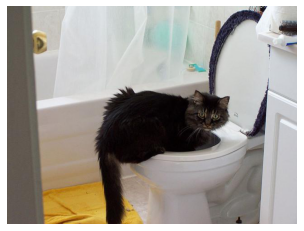

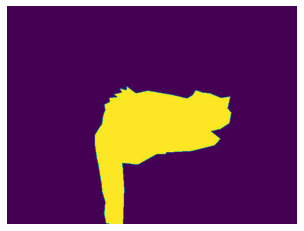

In [4]:
# Извлекаем картинки

num_of_id = 1
img = io.imread(DATA_DIR + f'img_{num_of_id}')
mask = io.imread(DATA_DIR + f'mask_{num_of_id}')
mask = mask[:,:,0]/255


# visualisation
plt.axis('off')
plt.imshow(img)
plt.show()
plt.axis('off')
plt.imshow(mask)
plt.show()

In [5]:
def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [37]:
WINDOW=128
MIN_OVERLAP=16
NEW_SIZE=256
NUMBER_OF_SAMPLES = 150

trfm = A.Compose([
    A.Resize(NEW_SIZE,NEW_SIZE),
#     A.HorizontalFlip(p=0.5),
#     A.ColorJitter (brightness=0.07, contrast=0.07,
#                    saturation=0.1, hue=0.1, always_apply=False, p=0.3)
])

In [38]:
class CoCoDataset(D.Dataset):

    def __init__(self, root_dir, transform,
                 window=256, overlap=32, threshold=0.25, number_of_samples = NUMBER_OF_SAMPLES):  
        self.path = root_dir  # папка
        self.overlap = overlap  # перекрытие плиток
        self.window = window  # размер окна
        self.transform = transform   # трансформации изображения (как минимум изменение размеров)
        self.threshold = threshold  # для отбрасывания плиток без кошки
        self.build_slices()
        self.len = len(self.slices)
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
    def build_slices(self):
        self.masks = [] # массив с масками. [id_of_image][h][w]
        self.slices = [] # массив со срезами [id_of_slice][4] (x1,x2,y1,y2)
        for num_of_id in range(NUMBER_OF_SAMPLES):
            mask = io.imread(self.path + f'mask_{num_of_id}')
            mask = mask[:,:,0]/255 # полная нормированная маска (числа [0, 1])
            self.masks.append(mask)

            slices = make_grid(mask.shape, window=self.window,
                                min_overlap=self.overlap) 
            for slc in slices:
                x1,x2,y1,y2 = slc
                if mask[x1:x2,y1:y2].sum() > self.threshold:
                    self.slices.append([num_of_id,x1,x2,y1,y2])
                        
    # get data operation
    def __getitem__(self, index):
        
        # index - это индекс среза, то есть "номер плитки"!
        
        num_of_id = self.slices[index][0]
        x1,x2,y1,y2 = self.slices[index][1:]
        img = io.imread(self.path + f'img_{num_of_id}')
        image = img[x1:x2,y1:y2].copy()       
        mask = self.masks[num_of_id][x1:x2,y1:y2]       
        augments = self.transform(image=image, mask=mask)
        #return image, mask
        return self.as_tensor(augments['image']), augments['mask'][None] #??????????????????
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len
    
train = CoCoDataset(DATA_DIR, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

In [39]:
img, mask = train[0]
print(img.shape)
print(mask.shape)
len(train.slices)

torch.Size([3, 256, 256])
(1, 256, 256)


2002

In [40]:
valid_idx, train_idx = [], []
for i in range(100):
    if train.slices[i][0] % 4 == 0: # отбор всех плиток, относящейся к каждой 4-ой картинке в валидационный датасет
        valid_idx.append(i)
    else:
        train_idx.append(i)
        
ppr(train_idx, 'train_idx')
ppr(valid_idx, 'valid_idx')

train_idx: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
valid_idx: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]


In [41]:
EPOCHES = 2
BATCH_SIZE = 5

In [42]:
train_ds = D.Subset(train, train_idx)
valid_ds = D.Subset(train, valid_idx)

loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# NETWORK

In [43]:
def get_model():
    ENCODER = 'se_resnext50_32x4d'
    ENCODER_WEIGHTS = 'imagenet'
    CLASSES_NUMBER = 1
    ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multicalss segmentation

    # create segmentation model with pretrained encoder
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        classes=CLASSES_NUMBER,
        activation=ACTIVATION,
    )

    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    return model

In [44]:
@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [45]:
DEVICE = 'cpu' ################################!!!!!!!
################################################
model = get_model()

model.to(DEVICE);

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

In [46]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
class SoftDiceBCEWithLogitsLoss:
    def __init__():
        self.bce_fn = nn.BCEWithLogitsLoss()
        self.dice_fn = SoftDiceLoss()
    
    def __call__(y_pred, y_true):
        self.bce = bce_fn(y_pred, y_true)
        self.dice = dice_fn(y_pred.sigmoid(), y_true)
        return 0.8*bce+ 0.2*dice
    
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice


In [47]:
### Table for results
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'
DEVICE

'cpu'

In [48]:
print(header)

for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    n_iter = 0
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
       
        optimizer.zero_grad()
        output = model(image)
        #ppr(output.shape,'shape_model:')
        #ppr(target.shape,'shape_target:')
        #ppr(output[0][0],'output:')
        
        
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        n_iter += 1
        if n_iter % 10 ==0:
            print(n_iter)
        losses.append(loss.item())
#         writer.add_scalar('Loss/train', loss.item(), n_iter)
    vloss = validation(model, vloader, loss_fn)
#     writer.add_scalar('Loss/val', vloss, n_iter)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []


        Train | Valid
Epoch |  Loss |  Loss | Time, m

10
     1│  0.743│  0.672│  1.37
10
     2│  0.709│  0.651│  1.38


In [62]:
def make_inverse_transform( mean_0=0.625, mean_1=0.448, mean_2=0.688, 
                           std_0=0.131, std_1=0.177, std_2= 0.101  ):
    return T.Compose([ T.Normalize(mean = [ 0., 0., 0. ],
                                                         std = [ 1/std_0, 1/std_1, 1/std_2 ]),
                                    T.Normalize(mean = [ -mean_0, -mean_1, -mean_2 ],
                                                         std = [ 1., 1., 1. ]),
                                   ])

invTrans = make_inverse_transform()


In [55]:
PATH_OF_MODEL = 'MyPytorchModel'
if os.path.exists(PATH_OF_MODEL):
    os.remove(PATH_OF_MODEL + '/model')
    os.rmdir(PATH_OF_MODEL)
os.mkdir(PATH_OF_MODEL)
torch.save(model.state_dict(), PATH_OF_MODEL + '/model')


In [58]:
# Downloading
model = get_model()
model.load_state_dict(torch.load(PATH_OF_MODEL + '/model'))
model.eval()

Unet(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
class CoCoDataset(D.Dataset):

    def __init__(self, root_dir, transform,
                 window=256, overlap=32, threshold=0.25, number_of_samples = NUMBER_OF_SAMPLES):  
        self.path = root_dir  # папка
        self.overlap = overlap  # перекрытие плиток
        self.window = window  # размер окна
        self.transform = transform   # трансформации изображения (как минимум изменение размеров)
        self.threshold = threshold  # для отбрасывания плиток без кошки
        self.build_slices()
        self.len = len(self.slices)
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
    def build_slices(self):
        #self.masks = [] # массив с масками. [id_of_image][h][w]
        self.slices = [] # массив со срезами [id_of_slice][4] (x1,x2,y1,y2)
        for num_of_id in range(NUMBER_OF_SAMPLES):
            #mask = io.imread(self.path + f'mask_{num_of_id}')
            #mask = mask[:,:,0]/255 # полная нормированная маска (числа [0, 1])
            #self.masks.append(mask)

            slices = make_grid(mask.shape, window=self.window,
                                min_overlap=self.overlap) 
            for slc in slices:
                x1,x2,y1,y2 = slc
                if mask[x1:x2,y1:y2].sum() > self.threshold:
                    self.slices.append([num_of_id,x1,x2,y1,y2])
                        
    # get data operation
    def __getitem__(self, index):
        
        # index - это индекс среза, то есть "номер плитки"!
        
        num_of_id = self.slices[index][0]
        x1,x2,y1,y2 = self.slices[index][1:]
        #img = io.imread(self.path + f'img_{num_of_id}')
        image = img[x1:x2,y1:y2].copy()       
        mask = self.masks[num_of_id][x1:x2,y1:y2]       
        augments = self.transform(image=image, mask=mask)
        #return image, mask
        return self.as_tensor(augments['image']), augments['mask'][None] #??????????????????
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len
    
train = CoCoDataset(DATA_DIR, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

 

In [90]:
as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])

name_img = 'img_5'
image = io.imread(DATA_DIR + name_img)
ppr(image.shape,'image_shape')
slices = make_grid([image.shape[0],image.shape[1]], window=WINDOW,
                                min_overlap=MIN_OVERLAP)
image_tensor_slices = []
for slc in slices:
    x1,x2,y1,y2 = slc
    img_slice = image[x1:x2,y1:y2]
    image_tensor = as_tensor(trfm(image=img_slice)['image'])
    print
    image_tensor_slices.append(image_tensor)
print(len(image_tensor_slices))

test_loader = D.DataLoader(
    image_tensor_slices, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

for image_input in test_loader:
    image_input = image_input.to(DEVICE)
    output = model(image_input)
    print(output.shape)

image_shape: (480, 640, 3)
30
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])
